In [1]:
#imports
import os
import math
import numpy as np
from numpy import unravel_index
import skimage
from skimage import io, data
from skimage.color import rgb2gray, rgba2rgb
import matplotlib.pyplot as plt
import sys



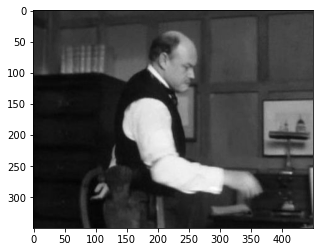

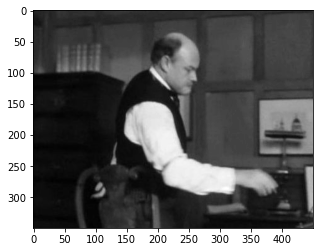

In [71]:
def load_image(image_path):
    filename = os.path.join(skimage.data_dir, image_path)

    image = io.imread(filename)

    # print("Input image shape:",image.shape)

    #ensure that our image is 2 channels only
    if (len(image.shape) == 2):
        return image
    else:
        if image.shape[2] == 4:
            image = rgb2gray(rgba2rgb(io.imread(filename)))
            image_uint8 = ((image - np.min(image)) * (1/(np.max(image) - np.min(image)) * 255)).astype('uint8')
            return image_uint8
        if image.shape[2] == 3:
            image = rgb2gray(io.imread(filename))
            image_uint8 = ((image - np.min(image)) * (1/(np.max(image) - np.min(image)) * 255)).astype('uint8')
            return image_uint8

def display_image(image):
    plt.imshow(image, cmap='gray')
    plt.show()

file_dir = os.path.dirname(os.path.realpath('__file__')) #<-- absolute dir the script is in
abs_file_path_im_1 = os.path.join(file_dir, 'data/people1.jpg')
abs_file_path_im_2 = os.path.join(file_dir, 'data/people2.jpg')
im_1 = load_image(abs_file_path_im_1)
im_2 = load_image(abs_file_path_im_2)

display_image(im_1)
display_image(im_2)

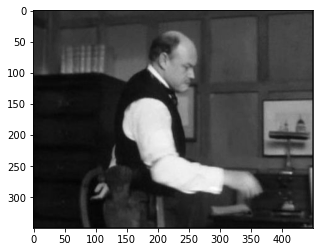

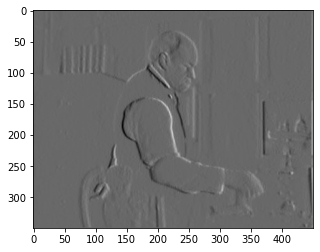

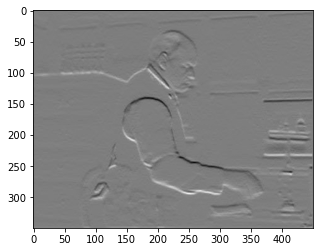

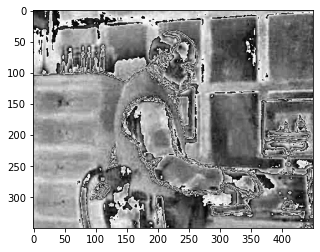

input image shape:  (350, 450)
processed image shape:  (350, 450)


In [78]:

#pad the image with the floor of width/2
def zero_pad_image(image, filter_width):
    pad_width = math.floor((filter_width/2))
    return np.pad(image,pad_width)

def create_gaussian_filter(sigma):
    
    # How to choose size n
    n = 2*math.floor(sigma*3)+1
    # Precompute sigma*sigma
    sigma2 = sigma*sigma
    
    # Create a coordinate sampling from -n/2 to n/2 so that (0,0) will be at the center of the filter
    x = np.linspace(-n/2.0, n/2.0, n)
    y = np.linspace(-n/2.0, n/2.0, n)
    
    # Blank array for the Gaussian filter
    gaussian_filter = np.zeros((n,n))

    # Loop over all elements of the filter
    for i in range(0, len(x)):
        for j in range(0, len(y)):
            
            # Use the x and y coordinate sampling as the inputs to the 2D Gaussian function
            gaussian_filter[i,j] = (1/(2*math.pi*sigma2))*math.exp(-(x[i]*x[i]+y[j]*y[j])/(2*sigma2))
      
    # Normalize so the filter sums to 1
    return gaussian_filter/np.sum(gaussian_filter.flatten())

def findOperationIndexPairs(idx,n,opType):
    indexPairs = []
    
    dist_to_corner = int((n/2))

    # the starting point (top left) of the image based on the filter size.
    img_start_idx = (idx[0] - dist_to_corner, idx[1]-dist_to_corner)

    for i in range(n):
        for j in range(n):
            x_img = img_start_idx[0] + i
            y_img = img_start_idx[1] + j

            # cross correlation
            if opType == 1:
                x_ker = i
                y_ker = j
                indexPairs.append(((x_img,y_img),(x_ker,y_ker)))
            
            # convolution
            # flip filter vertically and horizontally
            if opType == 0:
                x_ker = (n-1) - i
                y_ker = (n-1) - j
                indexPairs.append(((x_img,y_img),(x_ker,y_ker)))

    return indexPairs

# do convolution or cross correlation - feed in 0 = convolution
def convolution_xcorrelation(f, I, optype):

    filter_width = f.shape[0]

    image_width = I.shape[1]
    image_height = I.shape[0]

    pad_width = math.floor((filter_width/2))

    I_padded = zero_pad_image(I,filter_width)

    im_out = np.zeros((I.shape[0],I.shape[1]))
    

    top_left_image_idx = (pad_width,pad_width)
    bottom_right_image_idx = (pad_width+image_height-1,pad_width+image_width-1)
 

    for i in range(top_left_image_idx[0], bottom_right_image_idx[0]):
        for j in range(top_left_image_idx[1], bottom_right_image_idx[1]):

            image_pixel = (i,j)

            # pass optype to the function we created in an earlier assignment
            index_pairs = findOperationIndexPairs(image_pixel,filter_width,optype)
           
   
            val_sum = 0
            for pairing in index_pairs:
                image_idx = pairing[0]
                filter_idx = pairing[1]
                val_sum += I_padded[image_idx[0],image_idx[1]] * f[filter_idx[0],filter_idx[1]]

            im_out[(i-pad_width),(j-pad_width)] = val_sum 


    return im_out

def smooth_image(im_in):
    image = im_in
    g = create_gaussian_filter(0.5)
    smoothed_image = convolution_xcorrelation(g,image,0)
    return smoothed_image

def calculate_spatial_derivatives(im_in):

    image = im_in


    x_deriv =np.array([ [0,0,0],
                        [-1,0,1],
                        [0,0,0]])

    y_deriv = x_deriv.T


    # convolve the filter 
    x_deriv_image = convolution_xcorrelation(x_deriv,im_in,0)
    y_deriv_image = convolution_xcorrelation(y_deriv,im_in,0)


    return x_deriv_image,y_deriv_image

def calculate_temporal_derivative(im_1,im_2):
    out_im = im_2
    out_im -= im_1
    return out_im

smoothed_im_1 = smooth_image(im_1)

display_image(smoothed_im_1)

smoothed_im_2 = smooth_image(im_2)
x_deriv,y_deriv = calculate_spatial_derivatives(smoothed_im_1)
t_deriv = calculate_temporal_derivative(im_1,im_2)



display_image(x_deriv)
display_image(y_deriv)
display_image(t_deriv)

print("input image shape: ",im_1.shape)
print("processed image shape: ",x_deriv.shape)


-34.651648152307786
max. magnitude:  [26918.78379069]


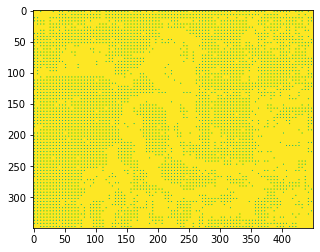

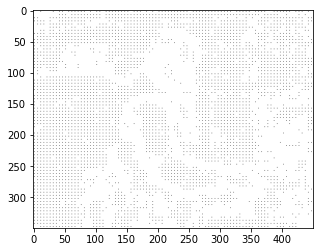

In [89]:

def get_patch_indices(y,x):
    patch_indices = [[y-2,x-2],[y-2,x-1],[y-2,x-0],[y-2,x+1],[y-2,x+2], 
                [y-1,x-2],[y-1,x-1],[y-1,x-0],[y-1,x-0],[y-1,x+2],                 
                [y-0,x-2],[y-0,x-1],[y-0,x-0],[y-0,x-0],[y-0,x+2],                 
                [y+1,x-2],[y+1,x-1],[y+1,x-0],[y+1,x-0],[y+1,x+2],                                                
                [y+2,x-2],[y+2,x-1],[y+2,x-0],[y+2,x-0],[y+2,x+2]]

    patch_indices = np.array(patch_indices)
    return patch_indices


def get_A(patch_indices,x_deriv,y_deriv):
    A = np.zeros(patch_indices.shape)
    for i in range(patch_indices.shape[0]):
        #(y,x) == (row,col)
        index = patch_indices[i,:]
        y = index[0]
        x = index[1]
        I_x = x_deriv[y,x]
        I_y = y_deriv[y,x]
        A[i,0],A[i,1] = I_x,I_y
    
    return A


def get_B(patch_indices,t_deriv):
    B = np.zeros((patch_indices.shape[0],1))
    for i in range(patch_indices.shape[0]):
        index = patch_indices[i,:]
        y = index[0]
        x = index[1]
        I_t = t_deriv[y,x]
        B[i] = I_t
    return B
print(x_deriv[0,0])




# patch_indices = get_patch_indices(2,2)
# A = get_A(patch_indices,x_deriv,y_deriv)
# b = get_B(patch_indices,t_deriv)

# solver_output = np.linalg.lstsq(A,-b,rcond=None)

# x = solver_output[0]

def calculate_flow_vectors(x_deriv,y_deriv,t_deriv):
    flow_magnitude_field = np.zeros((t_deriv.shape))
    patch_size = 5
    offset = int(np.floor(patch_size/2))

    maximum = 0

    for i in range(offset, im_1.shape[0] - offset,5):
        for j in range(offset, im_1.shape[1] - offset,5):

                    
            patch_indices = get_patch_indices(i,j)
            A = get_A(patch_indices,x_deriv,y_deriv)
            b = get_B(patch_indices,t_deriv)

            solver_output = np.linalg.lstsq(A,-b,rcond=None)

            x = solver_output[0]

            x_magnitude = np.sqrt(x.T.dot(x))[0]

            maximum = x_magnitude if x_magnitude > maximum else maximum
            

            flow_magnitude_field[i,j] = x_magnitude[0] 

    print("max. magnitude: ",maximum)

    return flow_magnitude_field

            


flow_magnitude_field = -calculate_flow_vectors(x_deriv,y_deriv,t_deriv)

flow_magnitude_field = flow_magnitude_field > -20

# for i in range(offset, im_1.shape[0] - offset,5):
#     for j in range(offset, im_1.shape[1] - offset,5):
#         if flow_magnitude_field[i,j] > 50:
#             flow_magnitude_field[i-1,j-1] = 255
#             flow_magnitude_field[i-0,j-1] = 255
#             flow_magnitude_field[i+1,j-1] = 255
#             flow_magnitude_field[i-1,j+0] = 255
#             flow_magnitude_field[i-0,j+0] = 255
#             flow_magnitude_field[i+1,j+0] = 255
#             flow_magnitude_field[i-1,j+1] = 255
#             flow_magnitude_field[i-0,j+1] = 255
#             flow_magnitude_field[i+1,j+1] = 255




plt.imshow(flow_magnitude_field)
plt.show()



display_image(flow_magnitude_field)




# print(A)
# print(b)
# print(x)

# print(A.shape)
# print(x.shape)
# print(b.shape)




